In [50]:
####################### BLOCK 1: IMPORTS AND UTILITIES #######################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

def prepare_data(data, selected_features):
    """
    Prepare data for clustering
    
    # Parameters
    data: pandas DataFrame or numpy array
    selected_features: list 
        If DataFrame: column names or indices
        If array: column indices
    """
    if isinstance(data, pd.DataFrame):
        if isinstance(selected_features[0], str):
            X = data[selected_features].values
            feature_names = selected_features
        else:
            X = data.iloc[:, selected_features].values
            feature_names = data.columns[selected_features].tolist()
    else:
        X = data[:, selected_features]
        feature_names = [f"Feature {i}" for i in selected_features]
    
    return X, feature_names

def plot_clusters(X, labels, feature_names, title="Clustering Results", ax=None):
    """Utility function to plot clustering results"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        ax.scatter(X[mask, 0], X[mask, 1], c=[color], label=f'Cluster {label}')
    
    ax.set_title(title)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.legend()
    return ax


def plot_clusters_comparison(X, labels, feature_names, color_feature_idx, title="Clustering Results", ax=None):
    """
    Plot clustering results with a color gradient based on a specified feature
    
    Parameters:
    X: array-like of shape (n_samples, n_features)
    labels: cluster labels
    feature_names: list of feature names
    color_feature_idx: index of feature to use for color gradient
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Different markers for different clusters
    markers = ['o', '^', 's', 'D', 'v']  # Add more if needed
    
    # Create scatter plot for each cluster
    for label, marker in zip(unique_labels, markers):
        mask = labels == label
        scatter = ax.scatter(X[mask, 0], 
                           X[mask, 1],
                           c=X[mask, color_feature_idx],
                           marker=marker,
                           label=f'Group {label}',
                           cmap='rainbow',
                           alpha=0.7)
    
    # Add colorbar
    plt.colorbar(scatter, label=feature_names[color_feature_idx])
    
    # Labels and title
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(title)
    ax.legend()
    
    return ax

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(X, labels, method_name, feature_names):
    """Evaluate clustering using multiple metrics"""
    # Skip if all points are noise (-1)
    if all(l == -1 for l in labels):
        print(f"{method_name}: All points classified as noise")
        return
    
    # Calculate metrics (excluding noise points for methods like DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]
    
    if len(np.unique(labels_clean)) > 1:  # Need at least 2 clusters
        sil_score = silhouette_score(X_clean, labels_clean)
        ch_score = calinski_harabasz_score(X_clean, labels_clean)
        db_score = davies_bouldin_score(X_clean, labels_clean)
        
        print(f"\n{method_name} Evaluation:")
        print(f"Silhouette Score: {sil_score:.3f} (higher is better, range: [-1, 1])")
        print(f"Calinski-Harabasz Score: {ch_score:.3f} (higher is better)")
        print(f"Davies-Bouldin Score: {db_score:.3f} (lower is better)")
        
        # Calculate cluster properties
        for cluster in np.unique(labels_clean):
            cluster_mask = labels_clean == cluster
            print(f"\nCluster {cluster} statistics:")
            for i, feat in enumerate(feature_names):
                values = X_clean[cluster_mask, i]
                print(f"{feat}: mean = {np.mean(values):.3f}, std = {np.std(values):.3f}")
                
                
def plot_clusters_by_membership(data, labels, plot_features, title="Clustering Results", ax=None):
    """
    Plot clustering results with different colors for each cluster
    
    Parameters:
    -----------
    data : pandas DataFrame
        Complete dataframe containing all features
    labels : array-like
        Cluster labels
    plot_features : tuple or list
        (x_feature_name, y_feature_name) to plot
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        ax.scatter(data[plot_features[0]][mask], 
                  data[plot_features[1]][mask], 
                  c=[color], 
                  label=f'Group {label}',
                  alpha=0.7)
    
    ax.set_xlabel(plot_features[0])
    ax.set_ylabel(plot_features[1])
    ax.set_title(title)
    ax.legend()
    return ax

def plot_clusters_with_dor(data, labels, plot_features, dor_values, title="Clustering Results", ax=None):
    """
    Plot clustering results with discrete DoR groups
    
    Parameters:
    -----------
    data : pandas DataFrame
        Complete dataframe containing all features
    labels : array-like
        Cluster labels
    plot_features : tuple or list
        (x_feature_name, y_feature_name) to plot
    dor_values : array-like
        DoR values for grouping
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create discrete DoR groups
    dor_groups = np.zeros_like(dor_values)
    dor_groups[(dor_values >= 0.3) & (dor_values < 0.6)] = 1
    dor_groups[dor_values >= 0.6] = 2
    
    # Define colors for each group
    colors = ['blue', 'green', 'red']
    labels = ['DoR 0-0.3', 'DoR 0.3-0.6', 'DoR 0.6-1.0']
    
    # Plot each DoR group
    for i, (color, label) in enumerate(zip(colors, labels)):
        mask = dor_groups == i
        if np.any(mask):
            ax.scatter(data[plot_features[0]][mask],
                      data[plot_features[1]][mask],
                      c=color,
                      label=label,
                      alpha=0.7)
    
    ax.set_xlabel(plot_features[0])
    ax.set_ylabel(plot_features[1])
    ax.set_title(title)
    ax.legend()
    return ax

In [51]:
####################### BLOCK 1b: PCA #######################

def apply_pca(X_scaled, n_components=3):
    """Apply PCA to scaled data"""
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Print explained variance ratio
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    return X_pca, pca

In [52]:
####################### BLOCK 2: K-MEANS #######################
def kmeans_clustering(data, selected_features, n_clusters=3):
    """
    Perform K-Means clustering
    
    # Note: Can determine optimal n_clusters using:
    # - Elbow method
    # - Silhouette analysis
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # X_pca, pca = apply_pca(X_scaled)  # if using PCA

    
    # Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++', n_init=10) #or init = k-means++???
    labels = kmeans.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "K-Means Clustering")
    #plt.show()
    return kmeans, labels



In [53]:
####################### BLOCK 3: DBSCAN #######################
def dbscan_clustering(data, selected_features, eps=15, min_samples=20):
    """
    Perform DBSCAN clustering
    
    # Note: Number of clusters is determined automatically
    # Can estimate eps using nearest neighbors plot
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    # #plot results
    #plot_clusters(X, labels, feature_names, "DBSCAN Clustering")
    #plt.show()
    
    return dbscan, labels

In [54]:
####################### BLOCK 4: MEAN SHIFT #######################
def meanshift_clustering(data, selected_features):
    """
    Perform Mean-Shift clustering
    
    # Note: Number of clusters is determined automatically
    # based on the data density
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Mean-Shift
    ms = MeanShift(bandwidth=2)
    labels = ms.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "Mean-Shift Clustering")
    #plt.show()
    
    return ms, labels

In [55]:
def gmm_clustering(data, selected_features, n_components=3):
    """
    Perform Gaussian Mixture clustering
    
    # Note: Can determine optimal n_components using:
    # - BIC (Bayesian Information Criterion)
    # - AIC (Akaike Information Criterion)
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42, n_init=10)
    labels = gmm.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "Gaussian Mixture Clustering")
    #plt.show()
    
    return gmm, labels

In [56]:
####################### BLOCK 6: HIERARCHICAL #######################
def hierarchical_clustering(data, selected_features, n_clusters=3):
    """
    Perform Hierarchical clustering
    
    # Note: Can determine optimal n_clusters using:
    # - Dendrogram analysis
    # - Silhouette analysis
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Hierarchical Clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    labels = hc.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "Hierarchical Clustering")
    #plt.show()
    
    return hc, labels

from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(data, selected_features, method='ward', figsize=(10,7)):
    """
    Plot dendrogram for hierarchical clustering
    
    Parameters:
    -----------
    data : DataFrame or array
    selected_features : list of features
    method : str, optional (default='ward')
        Linkage method: 'ward', 'complete', 'average', or 'single'
    """
    # Prepare and scale data
    X, feature_names = prepare_data(data, selected_features)
    X_scaled = StandardScaler().fit_transform(X)
    
    # Calculate linkage matrix
    Z = linkage(X_scaled, method=method)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    dendrogram(Z)
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()
    
    return Z



# USAGE + PLOTTING


In [57]:
"""select from ['GALAXY ID', 'ra', 'dec', 'plate', 'mjd', 'fiberid', 'objid', 'deVRad_r', 'deVRadErr_r', 'expRad_r', 'expRadErr_r', 'z', 'zErr', 'SNR', 'velDisp_SDSS', 'velDispErr_SDSS', 'velDisp_ppxf_full', 'velDisp_ppxf_err_full', 'velDisp_ppxf_res', 'velDisp_ppxf_err_res', 'logM*', 'errlogM*', 'logSFR', 'errlogSFR', 'logsSFR', 'errlogsSFR', 'petroR50Errkpc_r', 'petroR50kpc_r', 'deVRadkpc_r', 'deVRadErrkpc_r', 'expRadkpc_r', 'expRadErrkpc_r', 'fracDev_r', 'meanRad_r', 'meanRadErr_r', 'meanRadkpc_r', 'meanRadErrkpc_r', 'meanRad_kids', 'meanRadkpc_kids', 'Mgb_ssp', 'Fe_avg_ssp', 'Mgb_sigmacorr', 'Fe_avg_sigmacorr', 'MgFe', 'alphaFe_flag', 'univ_age', 'age_mean_mass', 'age_err_mass', 'age_mean_light', 'age_err_light', '[M/H]_mean_mass', '[M/H]_err_mass', '[M/H]_mean_light', '[M/H]_err_light', 'Mtbb3', 'Mtbb3_unr', 'Mtbb3_reg', 'Mtbb3_alphaplus', 'Mtbb3_alphamin', 't_75', 't_75_unr', 't_75_reg', 't_75_alphaplus', 't_75_alphamin', 't_90', 't_90_unr', 't_90_reg', 't_90_alphaplus', 't_90_alphamin', 't_100', 't_100_unr', 't_100_reg', 't_100_alphaplus', 't_100_alphamin', 'DoR']"""


clustering_features = ['MgFe', 'age_mean_mass', '[M/H]_mean_mass', 'velDisp_ppxf_res'] #, 'logM*','meanRadkpc_r', 'Mtbb3', 't_75', 't_100']
plot_features = ['age_mean_mass', '[M/H]_mean_mass', 'MgFe', 'velDisp_ppxf_res'] #, 'logM*','meanRadkpc_r', 'Mtbb3', 't_75', 't_100']


df = pd.read_csv('data/E-INSPIRE_I_master_catalogue.csv')
df = df.sample(frac=1).reset_index(drop=True)

In [58]:
####################### BLOCK 7: USAGE EXAMPLES #######################
df = pd.read_csv('data/E-INSPIRE_I_master_catalogue.csv')
df = df.sample(frac=1).reset_index(drop=True)

selected_features = clustering_features
dor_values = df['DoR'].values  # Get DoR separately for coloring

n_clusters = 3


# 1. K-Means Example
print("\n=== K-Means Clustering ===")
# Try different numbers of clusters

kmeans_model, kmeans_labels = kmeans_clustering(df, selected_features, n_clusters=n_clusters)
# Count samples in each cluster
unique, counts = np.unique(kmeans_labels, return_counts=True)
print(f"K-Means with {n_clusters} clusters:")
print(dict(zip(unique, counts)))




"""
# 2. DBSCAN Example
print("\n=== DBSCAN Clustering ===")
# Try different eps values
for eps in [0.3, 0.5, 0.7]:
    dbscan_model, dbscan_labels = dbscan_clustering(df, selected_features, 
                                                  eps=eps, 
                                                  min_samples=5)
    # Count samples in each cluster (-1 is noise)
    unique, counts = np.unique(dbscan_labels, return_counts=True)
    print(f"\nDBSCAN with eps={eps}:")
    print(dict(zip(unique, counts)))
    print(f"Number of clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")

"""




"""# 3. Mean-Shift Example
print("\n=== Mean-Shift Clustering ===")
ms_model, ms_labels = meanshift_clustering(df, selected_features)
# Count samples in each cluster
unique, counts = np.unique(ms_labels, return_counts=True)
print("Mean-Shift clusters:")
print(dict(zip(unique, counts)))
print(f"Number of clusters found: {len(unique)}")"""






# 4. Gaussian Mixture Example
print("\n=== Gaussian Mixture Clustering ===")
# Try different numbers of components

gmm_model, gmm_labels = gmm_clustering(df, selected_features, 
                                     n_components=n_clusters)
# Count samples in each cluster
unique, counts = np.unique(gmm_labels, return_counts=True)
print(f"\nGMM with 3 components:")
print(dict(zip(unique, counts)))

# Calculate BIC score correctly
X, _ = prepare_data(df, selected_features)
X_scaled = StandardScaler().fit_transform(X)
print(f"BIC Score: {gmm_model.bic(X_scaled)}")





# 5. Hierarchical Clustering Example
print("\n=== Hierarchical Clustering ===")
# Try different numbers of clusters

hc_model, hc_labels = hierarchical_clustering(df, selected_features, 
                                            n_clusters=n_clusters)
# Count samples in each cluster
unique, counts = np.unique(hc_labels, return_counts=True)
print(f"\nHierarchical with {n_clusters} clusters:")
print(dict(zip(unique, counts)))


=== K-Means Clustering ===
K-Means with 3 clusters:
{np.int32(0): np.int64(272), np.int32(1): np.int64(112), np.int32(2): np.int64(46)}

=== Gaussian Mixture Clustering ===

GMM with 3 components:
{np.int64(0): np.int64(205), np.int64(1): np.int64(88), np.int64(2): np.int64(137)}
BIC Score: 3965.24280363909

=== Hierarchical Clustering ===

Hierarchical with 3 clusters:
{np.int64(0): np.int64(109), np.int64(1): np.int64(292), np.int64(2): np.int64(29)}


In [59]:
methods = {
   "K-Means": kmeans_labels,
   #"DBSCAN": dbscan_labels,
   #"Mean-Shift": ms_labels,
   "GMM": gmm_labels,
   "Hierarchical": hc_labels
}

In [60]:

# Evaluate all methods
print("\n=== Clustering Evaluation ===")


for method_name, labels in methods.items():
   evaluate_clustering(X_scaled, labels, method_name, clustering_features)
   print("\n" + "="*50 + "\n")  # Separator between methods


# Print summary statistics
print("\nSummary of Results:")

for method_name, labels in methods.items():
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"\n{method_name}:")
    print(f"Number of clusters: {n_clusters}")
    print("Cluster sizes:", dict(zip(range(n_clusters), 
          np.bincount(labels[labels >= 0]))))


=== Clustering Evaluation ===

K-Means Evaluation:
Silhouette Score: 0.325 (higher is better, range: [-1, 1])
Calinski-Harabasz Score: 164.480 (higher is better)
Davies-Bouldin Score: 1.164 (lower is better)

Cluster 0 statistics:
MgFe: mean = 0.139, std = 0.915
age_mean_mass: mean = 0.503, std = 0.389
[M/H]_mean_mass: mean = 0.347, std = 0.494
velDisp_ppxf_res: mean = -0.209, std = 0.519

Cluster 1 statistics:
MgFe: mean = -0.489, std = 1.063
age_mean_mass: mean = -1.400, std = 0.862
[M/H]_mean_mass: mean = -1.051, std = 1.279
velDisp_ppxf_res: mean = -0.382, std = 0.734

Cluster 2 statistics:
MgFe: mean = 0.368, std = 0.905
age_mean_mass: mean = 0.432, std = 0.430
[M/H]_mean_mass: mean = 0.509, std = 0.508
velDisp_ppxf_res: mean = 2.169, std = 1.060



GMM Evaluation:
Silhouette Score: 0.095 (higher is better, range: [-1, 1])
Calinski-Harabasz Score: 103.033 (higher is better)
Davies-Bouldin Score: 1.825 (lower is better)

Cluster 0 statistics:
MgFe: mean = 0.091, std = 0.885
age_me

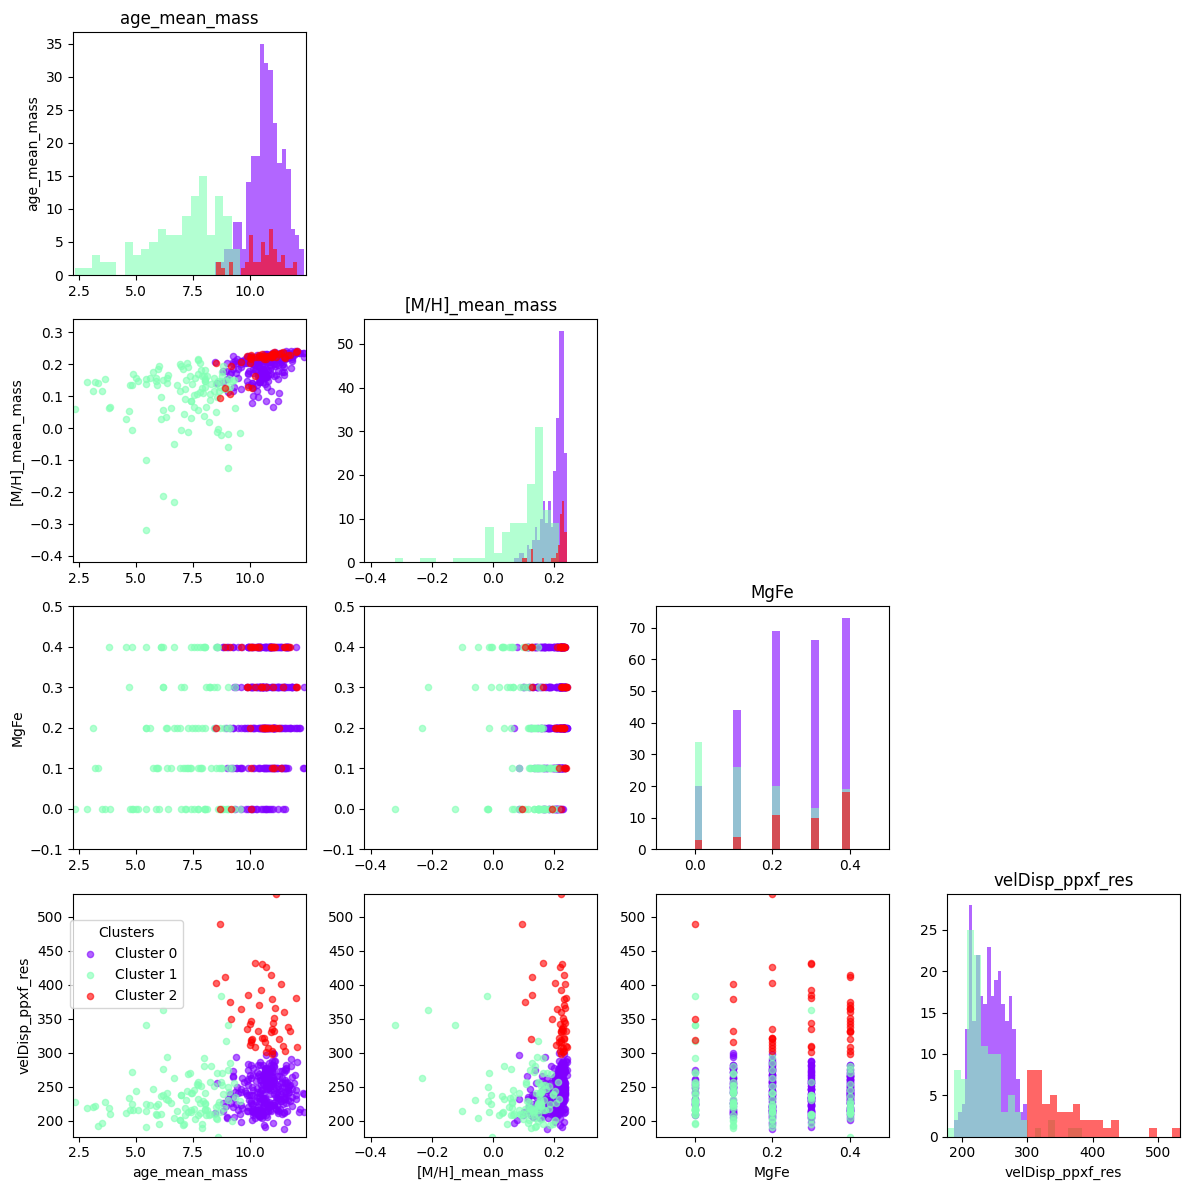

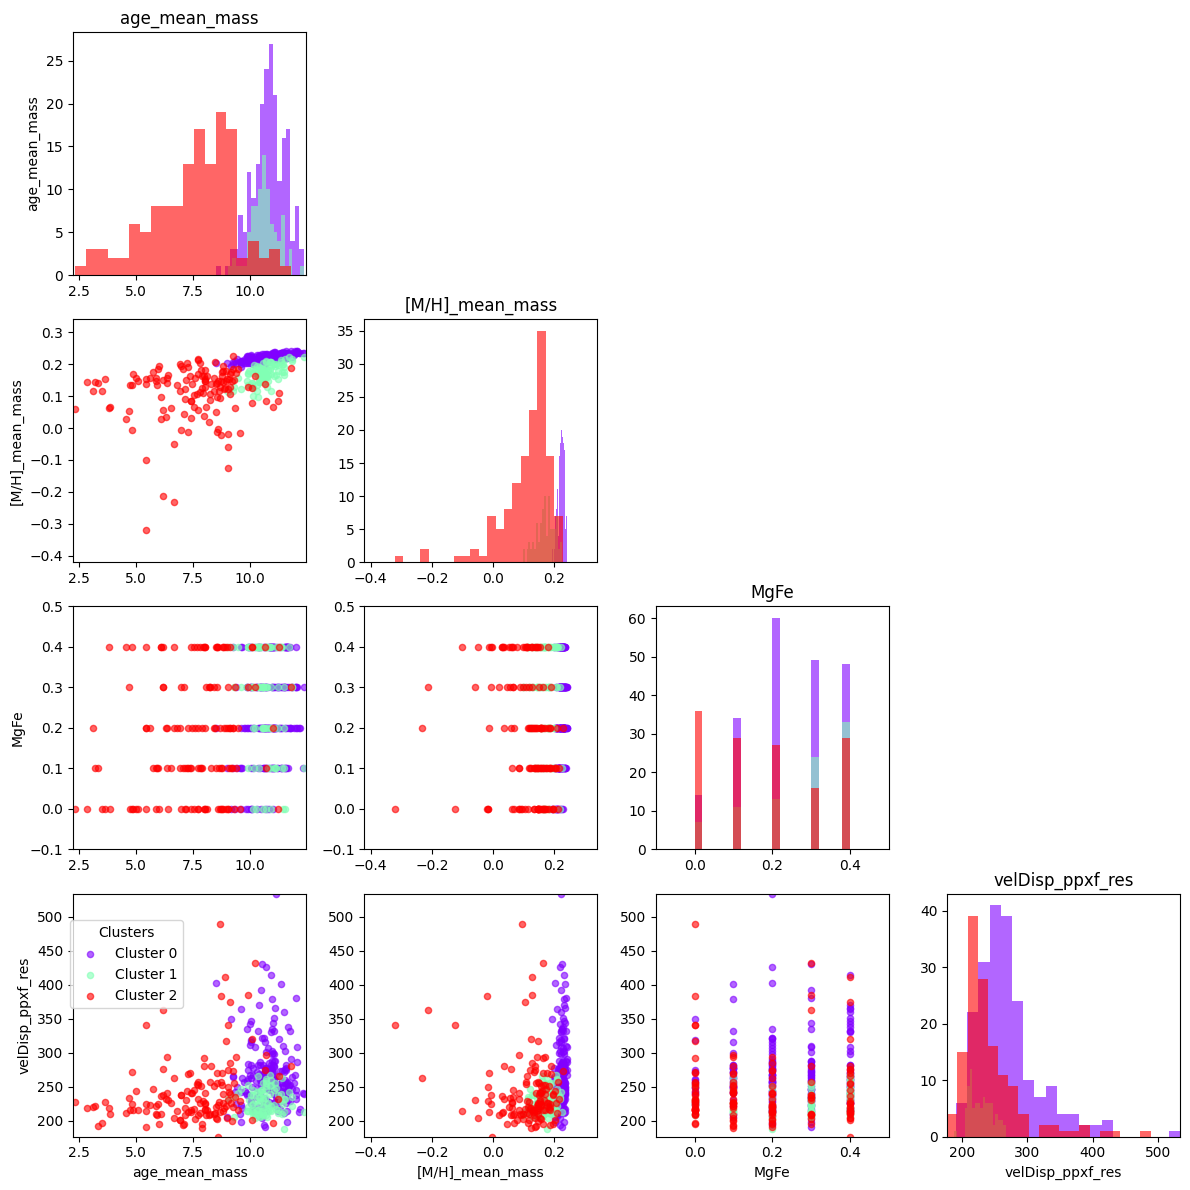

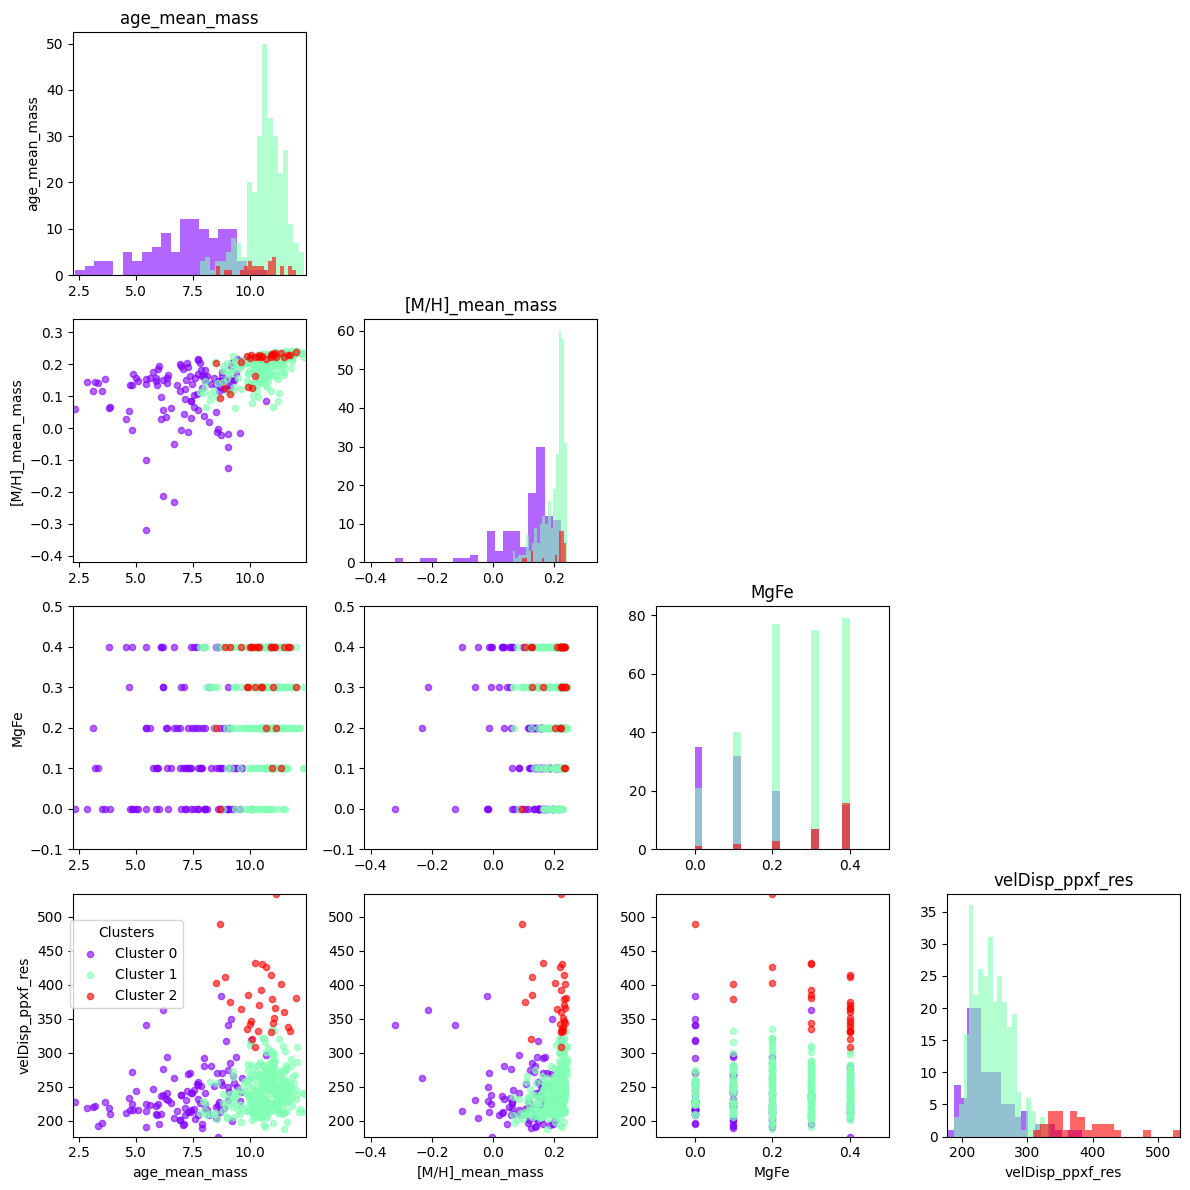

In [61]:
def make_corner_plot(data, labels, plot_features, method_name, figsize=(12, 12)):
    """
    Create a corner plot showing all pairwise relationships between features
    """
    n_features = len(plot_features)
    fig, axes = plt.subplots(n_features, n_features, figsize=figsize)
    
    # Get unique labels and colors
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    padding = 0.1
    
    for i in range(n_features):
        for j in range(n_features):
            ax = axes[i, j]
            
            if i < j:  # Upper triangle
                ax.set_visible(False)
                continue
                
            xmin = min(data[plot_features[j]]) - padding
            xmax = max(data[plot_features[j]]) + padding
            ymin = min(data[plot_features[i]]) - padding
            ymax = max(data[plot_features[i]]) + padding
                
            if i == j:  # Diagonal
                for label, color in zip(unique_labels, colors):
                    mask = labels == label
                    ax.hist(data[plot_features[i]][mask], bins=20, 
                           color=color, alpha=0.6, label=f'Cluster {label}')
                ax.set_xlim(xmin, xmax)
                ax.set_title(plot_features[i])
            else:  # Lower triangle
                for label, color in zip(unique_labels, colors):
                    mask = labels == label
                    ax.scatter(data[plot_features[j]][mask], 
                             data[plot_features[i]][mask],
                             c=[color], alpha=0.6, s=20, label=f'Cluster {label}')
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)
            
            # Labels
            if i == n_features-1:
                ax.set_xlabel(plot_features[j])
            if j == 0:
                ax.set_ylabel(plot_features[i])
                
            # Only show legend once in the first subplot
            if i == n_features-1 and j == 0:
                ax.legend(title="Clusters", bbox_to_anchor=(0.5, 0.5))

    #plt.suptitle(f'{method_name} Corner Plot', y=1.02)
    plt.tight_layout()
    return fig

for method_name, labels in methods.items():
    fig = make_corner_plot(df, labels, plot_features, method_name)
    plt.show()

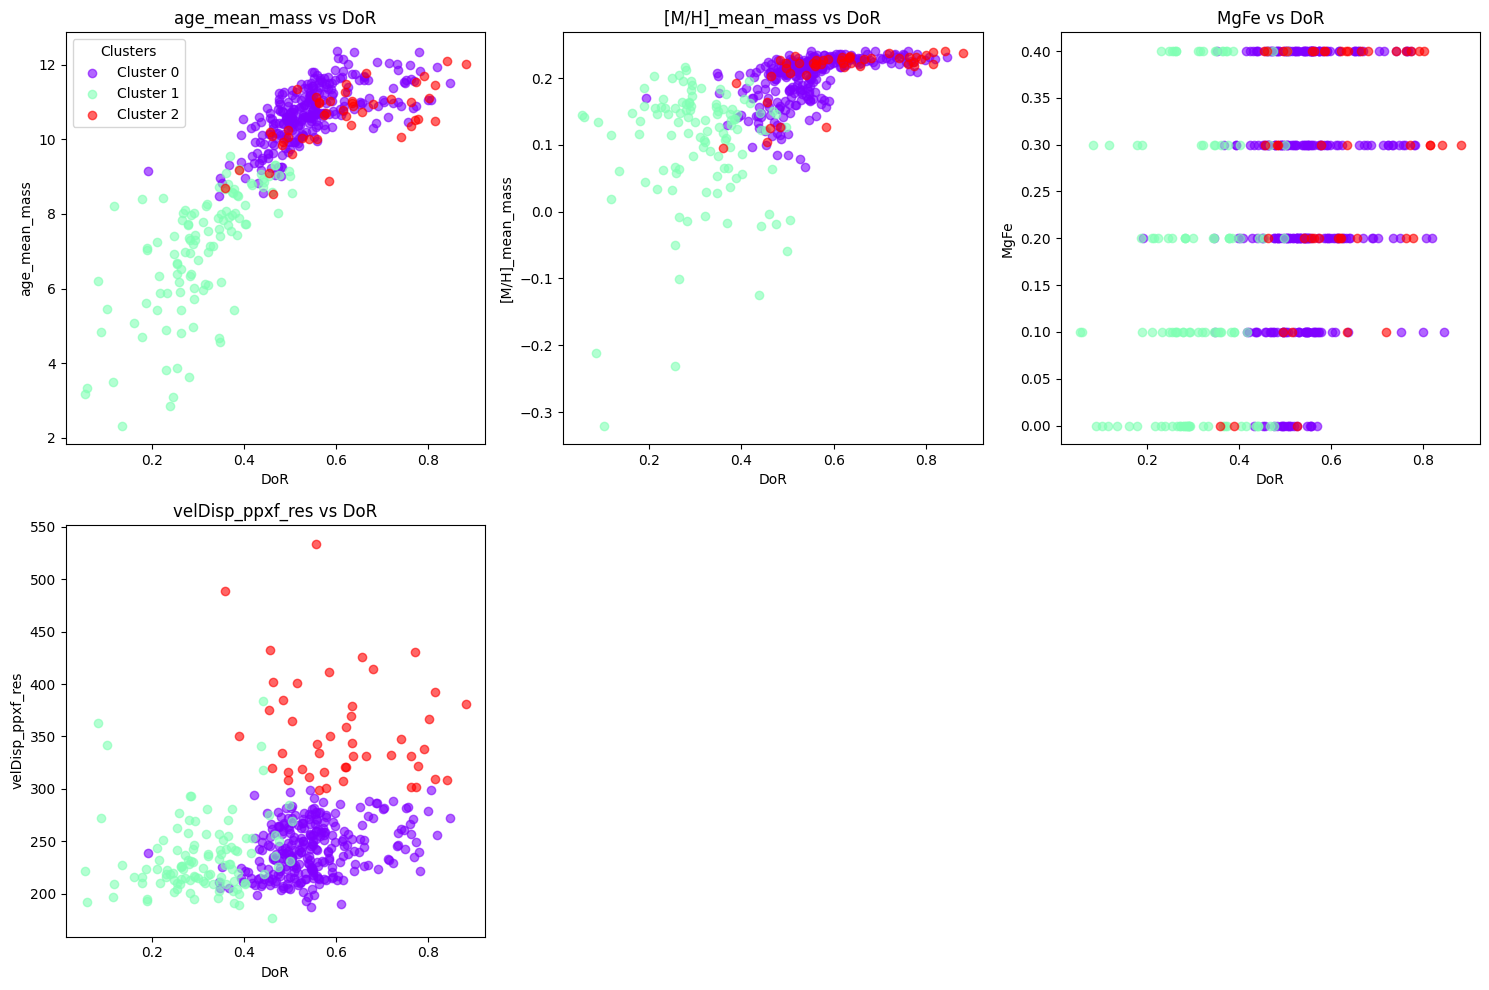

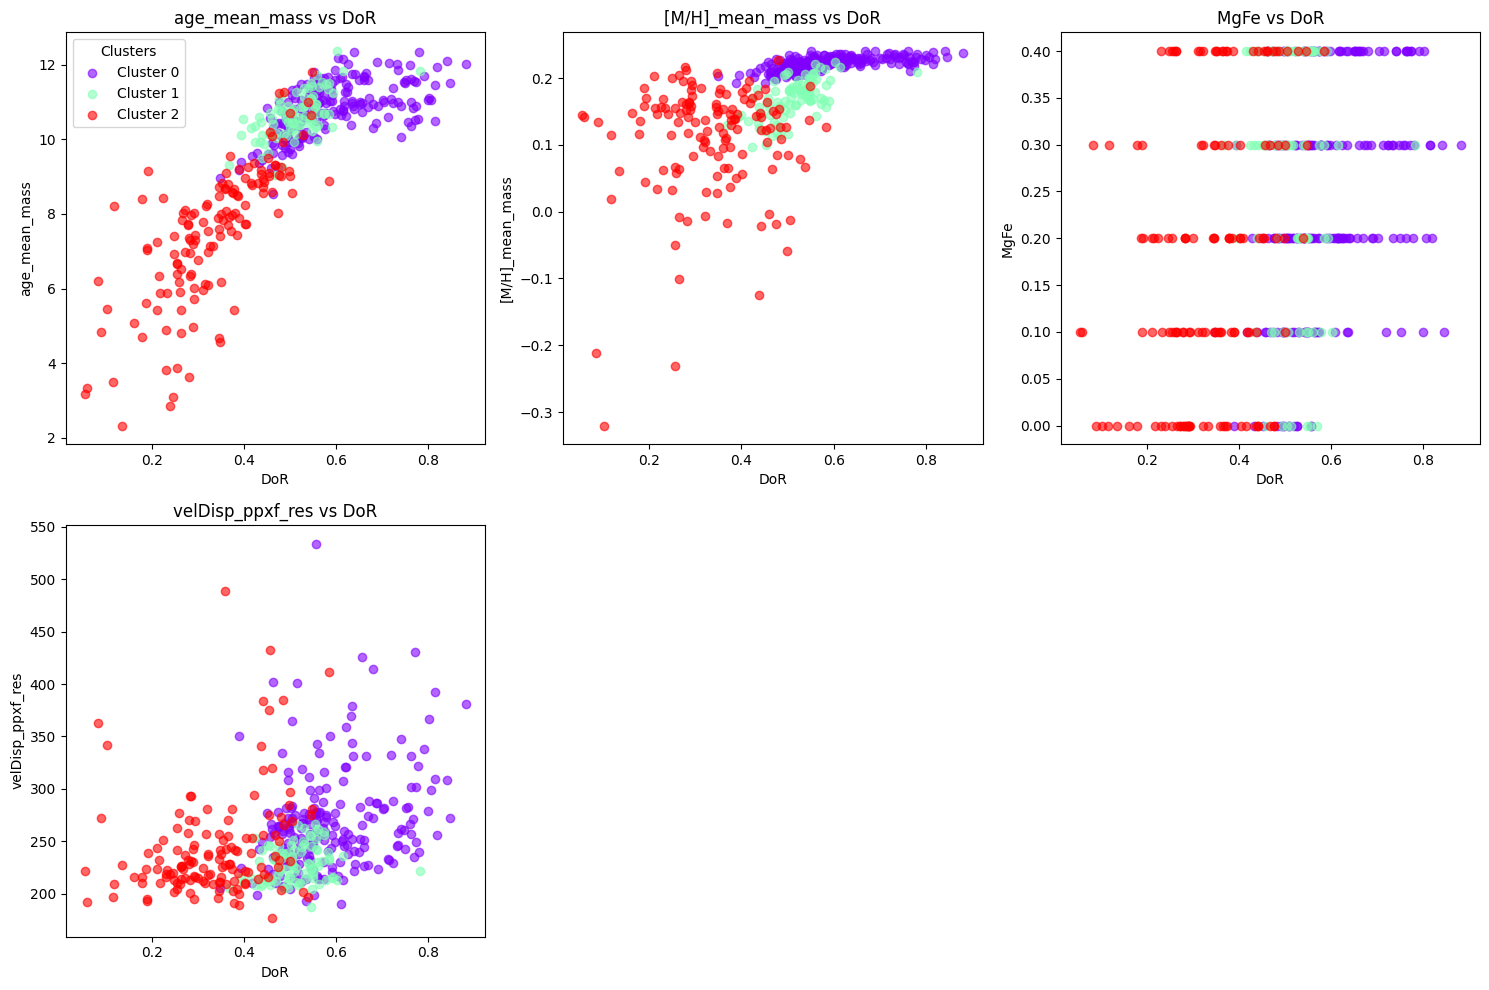

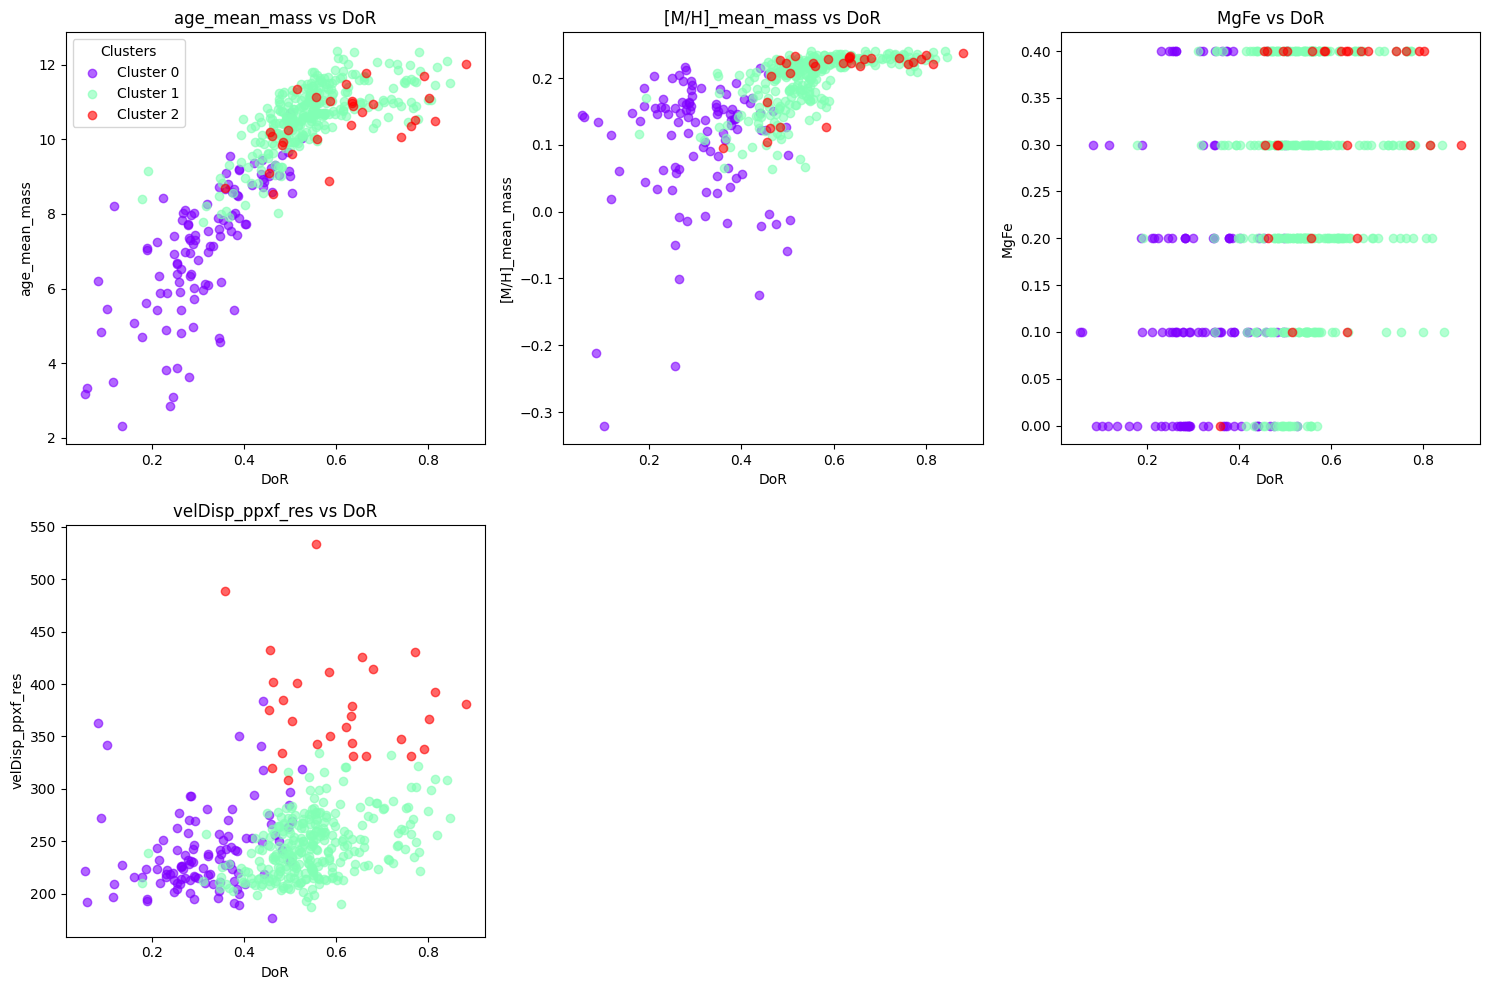

In [62]:
def plot_features_vs_dor(data, labels, features, method_name, figsize=(15, 10)):
    """
    Plot each feature against DoR, colored by cluster assignment
    """
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Get unique labels and colors
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    # Create plots
    for idx, feature in enumerate(features):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Plot scatter for each cluster
        for label, color in zip(unique_labels, colors):
            mask = labels == label
            ax.scatter(data['DoR'][mask], data[feature][mask],
                      c=[color], alpha=0.6, label=f'Cluster {label}')
            
        ax.set_xlabel('DoR')
        ax.set_ylabel(feature)
        ax.set_title(f'{feature} vs DoR')
        
        # Only show legend for first plot
        if idx == 0:
            ax.legend(title="Clusters")
    
    # Remove empty subplots
    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    # plt.suptitle(f'{method_name}: Features vs DoR', y=1.02)
    plt.tight_layout()
    return fig


for method_name, labels in methods.items():
    fig = plot_features_vs_dor(df, labels, plot_features, method_name)
    plt.show()

In [63]:
def export_clustering_results(df, methods, output_dir='cluster_results'):
    """
    Export clustering results to CSV files using SDSS spectroscopic identifiers
    
    Parameters:
    -----------
    df : pandas DataFrame
        Original dataframe containing galaxy information
    methods : dict
        Dictionary of method names and their corresponding cluster labels
    output_dir : str
        Directory to save the CSV files (default: 'cluster_results')
    """
    import os
    
    # Get current working directory
    current_dir = os.getcwd()
    print(f"Current working directory: {current_dir}")
    
    # Create full path for output directory
    output_path = os.path.join(current_dir, output_dir)
    os.makedirs(output_path, exist_ok=True)
    
    # Create SDSS identifiers
    sdss_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(df['plate'], df['mjd'], df['fiberid'])]
    
    # Export results for each method
    for method_name, labels in methods.items():
        # Create a new dataframe with SDSS ID and cluster assignment
        results_df = pd.DataFrame({
            'SDSS_ID': sdss_ids,
            'Cluster': labels
        })
        
        # Sort by cluster number
        results_df = results_df.sort_values('Cluster')
        
        # Create filename
        filename = os.path.join(output_path, f'{method_name.lower().replace(" ", "_")}_clusters.csv')
        
        # Save to CSV
        results_df.to_csv(filename, index=False)
        
        # Verify file was created
        if os.path.exists(filename):
            print(f"Successfully exported {method_name} results to {filename}")
            print(f"File size: {os.path.getsize(filename)} bytes")
            
            # Display first few rows as verification
            print(f"\nFirst few rows of {method_name} results:")
            print(results_df.head())
            print("\n" + "="*50 + "\n")
        else:
            print(f"Error: Failed to create file {filename}")

# Create the methods dictionary
methods = {
    "K-Means": kmeans_labels,
    "GMM": gmm_labels,
    "Hierarchical": hc_labels
}

# Export the results
export_clustering_results(df, methods)

Current working directory: /Users/charl/Documents/PythonPlay/AS01_Testing
Successfully exported K-Means results to /Users/charl/Documents/PythonPlay/AS01_Testing/cluster_results/k-means_clusters.csv
File size: 12056 bytes

First few rows of K-Means results:
                       SDSS_ID  Cluster
214  spec-1435-52996-0462.fits        0
200  spec-0741-52261-0325.fits        0
199  spec-2570-54081-0192.fits        0
198  spec-5948-56107-0226.fits        0
197  spec-1938-53379-0028.fits        0


Successfully exported GMM results to /Users/charl/Documents/PythonPlay/AS01_Testing/cluster_results/gmm_clusters.csv
File size: 12056 bytes

First few rows of GMM results:
                       SDSS_ID  Cluster
160  spec-2571-54055-0057.fits        0
173  spec-2002-53471-0194.fits        0
174  spec-2760-54506-0191.fits        0
176  spec-0303-51615-0290.fits        0
366  spec-4494-55569-0432.fits        0


Successfully exported Hierarchical results to /Users/charl/Documents/PythonPlay/AS01_T

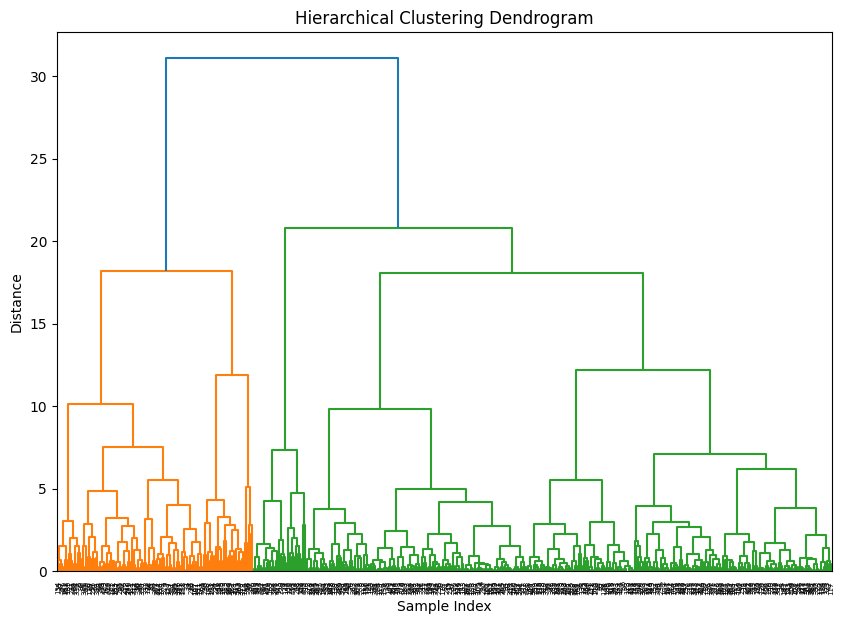

In [64]:
# Usage:
Z = plot_dendrogram(df, selected_features)

In [65]:
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                           davies_bouldin_score, adjusted_rand_score, 
                           adjusted_mutual_info_score, v_measure_score,
                           homogeneity_score, completeness_score,
                           confusion_matrix)
import numpy as np

def create_dor_labels(dor_values):
    """Convert continuous DoR values to discrete labels"""
    dor_labels = np.zeros_like(dor_values, dtype=int)
    dor_labels[(dor_values >= 0.3) & (dor_values < 0.6)] = 1
    dor_labels[dor_values >= 0.6] = 2
    return dor_labels

def align_labels(pred_labels, true_labels):
    """
    Align cluster labels to best match true labels using confusion matrix
    
    Parameters:
    -----------
    pred_labels : array-like
        Predicted cluster labels
    true_labels : array-like
        True labels to align with
        
    Returns:
    --------
    aligned_labels : array-like
        New labels aligned with true labels
    """
    # Create confusion matrix
    conf_mat = confusion_matrix(true_labels, pred_labels)
    
    # Find best matching pairs
    n_clusters = conf_mat.shape[1]
    aligned_labels = np.zeros_like(pred_labels)
    used_true = set()
    used_pred = set()
    
    # For each cluster, find the best match
    while len(used_true) < n_clusters:
        # Find maximum value in confusion matrix
        max_val = 0
        best_true = 0
        best_pred = 0
        
        for i in range(n_clusters):
            if i in used_true:
                continue
            for j in range(n_clusters):
                if j in used_pred:
                    continue
                if conf_mat[i, j] > max_val:
                    max_val = conf_mat[i, j]
                    best_true = i
                    best_pred = j
        
        # Assign new label
        aligned_labels[pred_labels == best_pred] = best_true
        used_true.add(best_true)
        used_pred.add(best_pred)
    
    return aligned_labels

def evaluate_clustering_simplified(X, labels, dor_values=None):
    """Simplified clustering evaluation with aligned labels"""
    results = {}
    
    # Basic cluster information
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    # Skip if only one cluster or all noise points
    if n_clusters < 2:
        return {"error": "Insufficient number of clusters for evaluation"}
    
    # Exclude noise points if any
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]
    
    # Calculate internal metrics (these don't need alignment)
    results['internal_metrics'] = {
        'silhouette': silhouette_score(X_clean, labels_clean),
        'calinski_harabasz': calinski_harabasz_score(X_clean, labels_clean),
        'davies_bouldin': davies_bouldin_score(X_clean, labels_clean)
    }
    
    # Calculate external metrics with aligned labels
    if dor_values is not None:
        dor_labels = create_dor_labels(dor_values[mask])
        
        # Align the cluster labels with DoR groups
        aligned_labels = align_labels(labels_clean, dor_labels)
        
        # Calculate metrics using aligned labels
        results['external_metrics'] = {
            'adjusted_rand': adjusted_rand_score(dor_labels, aligned_labels),
            'adjusted_mutual_info': adjusted_mutual_info_score(dor_labels, aligned_labels),
            'v_measure': v_measure_score(dor_labels, aligned_labels),
            'homogeneity': homogeneity_score(dor_labels, aligned_labels),
            'completeness': completeness_score(dor_labels, aligned_labels)
        }
        
        # Add confusion matrix
        results['confusion_matrix'] = confusion_matrix(dor_labels, aligned_labels)
    
    return results

def print_metrics_comparison(all_results):
    """Print a comparison of metrics across all methods"""
    # Print internal metrics comparison
    print("\n=== Internal Metrics Comparison ===")
    metrics = ['silhouette', 'calinski_harabasz', 'davies_bouldin']
    
    # Create header
    print(f"{'Method':<15}", end='')
    for metric in metrics:
        print(f"{metric:<20}", end='')
    print()
    print("-" * (15 + 20 * len(metrics)))
    
    # Print values for each method
    for method, results in all_results.items():
        if 'internal_metrics' in results:
            print(f"{method:<15}", end='')
            for metric in metrics:
                value = results['internal_metrics'][metric]
                print(f"{value:< 20.3f}", end='')
            print()
    
    # Print external metrics comparison if available
    if any('external_metrics' in results for results in all_results.values()):
        print("\n=== External Metrics Comparison (vs DoR groups) ===")
        metrics = ['adjusted_rand', 'adjusted_mutual_info', 'v_measure', 
                  'homogeneity', 'completeness']
        
        # Create header
        print(f"{'Method':<15}", end='')
        for metric in metrics:
            print(f"{metric:<20}", end='')
        print()
        print("-" * (15 + 20 * len(metrics)))
        
        # Print values for each method
        for method, results in all_results.items():
            if 'external_metrics' in results:
                print(f"{method:<15}", end='')
                for metric in metrics:
                    value = results['external_metrics'][metric]
                    print(f"{value:< 20.3f}", end='')
                print()
        
        # Print confusion matrices
        print("\n=== Confusion Matrices (DoR groups vs Aligned Clusters) ===")
        for method, results in all_results.items():
            if 'confusion_matrix' in results:
                print(f"\n{method}:")
                print("Rows: DoR groups (0: 0-0.3, 1: 0.3-0.6, 2: 0.6-1.0)")
                print("Columns: Aligned cluster labels")
                print(results['confusion_matrix'])

def evaluate_all_methods_simplified(methods, X, dor_values):
    """Evaluate all clustering methods with simplified metrics"""
    all_results = {}
    
    for method_name, labels in methods.items():
        results = evaluate_clustering_simplified(X, labels, dor_values)
        all_results[method_name] = results
    
    # Print comparison table
    print_metrics_comparison(all_results)
    
    return all_results



# After your clustering
X, _ = prepare_data(df, selected_features)
X_scaled = StandardScaler().fit_transform(X)

# Evaluate all methods with aligned labels
results = evaluate_all_methods_simplified(methods, X_scaled, df['DoR'].values)


=== Internal Metrics Comparison ===
Method         silhouette          calinski_harabasz   davies_bouldin      
---------------------------------------------------------------------------
K-Means         0.325               164.480             1.164              
GMM             0.095               103.033             1.825              
Hierarchical    0.338               146.783             1.150              

=== External Metrics Comparison (vs DoR groups) ===
Method         adjusted_rand       adjusted_mutual_infov_measure           homogeneity         completeness        
-------------------------------------------------------------------------------------------------------------------
K-Means         0.227               0.283               0.287               0.294               0.281              
GMM             0.077               0.292               0.296               0.331               0.267              
Hierarchical    0.221               0.277               0.281     